# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input Data
'data/processed/all_ghg_aligned_nan.csv'

## Stages
1. train/test split
2. test data transformations (log and differencing)
3. Auto-ARIMA parameter search
4. SARIMA model selection

In [131]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.preprocessing import GasPreprocessor
from src.model_evaluation import evaluate_sarima_model
print('GasPreprocessor imported successfully!')
print('evaluate_sarima_model imported successfully!')

GasPreprocessor imported successfully!
evaluate_sarima_model imported successfully!


# Load the Data

In [133]:
df_combined = pd.read_csv('../data/processed/all_ghg_aligned_nan.csv',
                          parse_dates=['date'], index_col='date')

In [134]:
df_combined['CH4'].head()

date
1969-08-20   NaN
1969-08-27   NaN
1969-09-02   NaN
1969-09-12   NaN
1969-09-24   NaN
Name: CH4, dtype: float64

In [135]:
df_combined['CH4'].tail(10)

date
2024-12-24    1952.380
2024-12-31    1977.445
2025-01-03         NaN
2025-01-07         NaN
2025-01-14         NaN
2025-01-21         NaN
2025-01-29         NaN
2025-02-11         NaN
2025-02-25         NaN
2025-04-03         NaN
Name: CH4, dtype: float64

In [136]:
# determine the first and last valid index for the CH4 series.  
# Note: df_combined is a concatenated and pivoted dataframe of 6 greenhouse gases that were aligned based on 
# data collection date.  So, there will certainly be missing values at the beginning of 5 of the 6 gas data series.  

print("First CH4 data point:", df_combined['CH4'].first_valid_index())
print("Last CH4 data point:", df_combined['CH4'].last_valid_index())
print("\nInitial gap duration:", df_combined['CH4'].first_valid_index() - df_combined['CH4'].index[0])
print("End gap duration:", df_combined['CH4'].index[-1] - df_combined['CH4'].last_valid_index())

First CH4 data point: 1983-05-06 00:00:00
Last CH4 data point: 2024-12-31 00:00:00

Initial gap duration: 5007 days 00:00:00
End gap duration: 93 days 00:00:00


**NOTE:** The GasPreprocessor class has methods to trim the initial and trailing NaNs.  However, an accurate train/test split is more dependent on trailing NaNs since they would be further trimmed during preprocessed by the GasPreprocessor class resulting in a smaller test set than expected.  So, I will trim the trailing NaNs prior to train/test split.  

# Split the Data Into Training and Testing Sets

In [138]:
# Trim trailing NaNs prior to train/test split

def trim_trailing_nans(series):
    '''
    Trim trailing NaN values from a series.
    '''
    last_valid_idx = series.last_valid_index()
    if last_valid_idx is not None and last_valid_idx < series.index[-1]:
        print(f'Trimming {len(series.loc[last_valid_idx:]) - 1} trailing NaN values from the raw series')
        return series.loc[:last_valid_idx]
    return series

In [141]:
# create CH4 series with trimmed trailing NaNs

ch4_clean = trim_trailing_nans(df_combined['CH4'])
ch4_clean_df = ch4_clean.reset_index() # convert back to DataFrame with date column

print(f'CH4 raw data: {len(df_combined['CH4'])} points, from {df_combined['CH4'].index.min()} to {df_combined['CH4'].index.max()}')
print(f'CH4 raw data trimmed of trailing NaNs: {len(ch4_clean)} points, from {ch4_clean.index.min()} to {ch4_clean.index.max()}')

Trimming 8 trailing NaN values from the raw series
CH4 raw data: 2562 points, from 1969-08-20 00:00:00 to 2025-04-03 00:00:00
CH4 raw data trimmed of trailing NaNs: 2554 points, from 1969-08-20 00:00:00 to 2024-12-31 00:00:00


In [142]:
test_size = 52 # one year of weekly data

CH4_train = ch4_clean.iloc[:-test_size]
CH4_test = ch4_clean.iloc[-test_size:]

print(f'Train data: {CH4_train.shape[0]} data points, from {CH4_train.index.min()} to {CH4_train.index.max()}')
print(f'Test data: {CH4_test.shape[0]} data points, from {CH4_test.index.min()} to {CH4_test.index.max()}')

Train data: 2502 data points, from 1969-08-20 00:00:00 to 2023-10-17 00:00:00
Test data: 52 data points, from 2023-10-24 00:00:00 to 2024-12-31 00:00:00


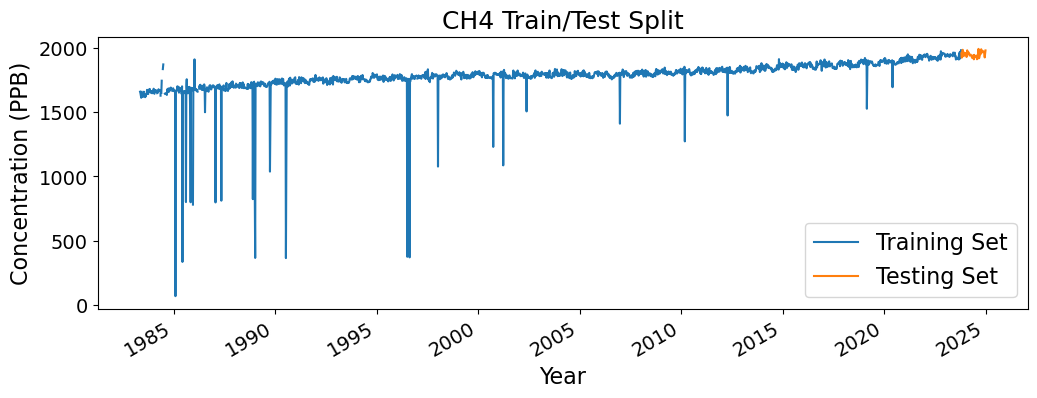

In [144]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
CH4_train.plot(ax=ax, label='Training Set')
CH4_test.plot(ax=ax, label='Testing Set')

ax.legend(fontsize=16)
ax.set_title('CH4 Train/Test Split', fontsize=18)
ax.set_ylabel('Concentration (PPB)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

## Proprocessing and EDA of CH4 Train Set

In [145]:
# reset index to make 'date' column

CH4_train_with_date = CH4_train.reset_index()
CH4_test_with_date = CH4_test.reset_index()


[INFO] Fitting preprocessing for CH4
Trimming 388 leading NaN values
Raw data: 2502 points, 432 NaNs
Trimmed data: 2114 points, 44 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
After resampling: 2112 points, 67 NaNs
[INFO] Found 150 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 217 NaNs
After smoothing: 2112 points, 1 NaNs
After interpolation: 2112 points, 0 NaNs


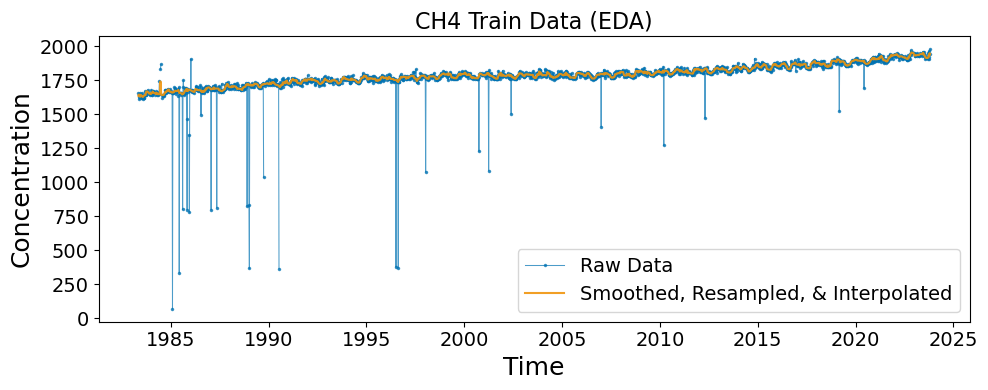

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -1.0139
ADF p-value 0.7481
ADF critical values: {'1%': -3.433479704613104, '5%': -2.8629225683793083, '10%': -2.5675060146913125}

KPSS statistic 6.6953
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  


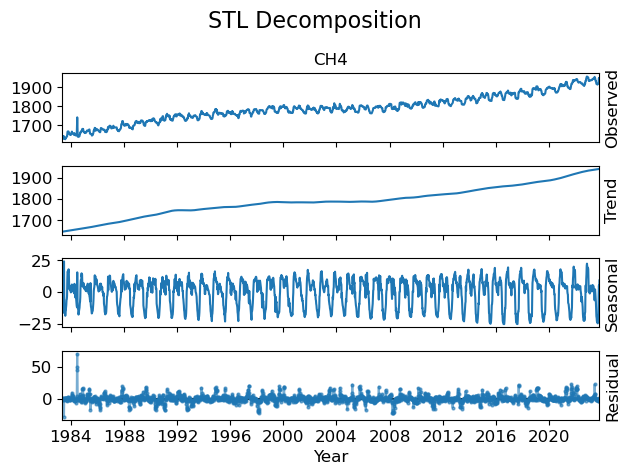

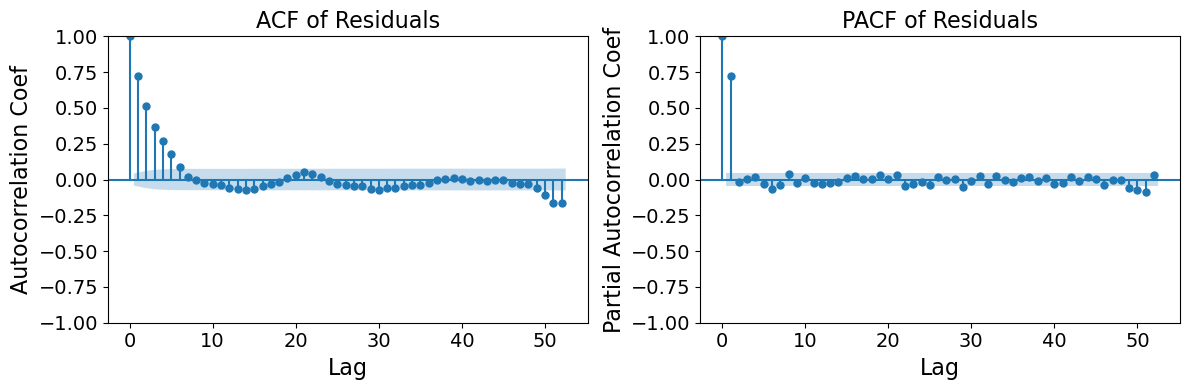


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0196
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0028
Heteroscedasticity detected (White test)
Trimming 388 leading NaN values


In [146]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

CH4_train_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
CH4_train_preprocessed = CH4_train_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_preprocessed = CH4_train_preprocessor.transform(CH4_test_with_date)

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling negative values, NaNs, and outliers while preserving the seasonality and trend.  The ADF and KPSS tests confirm that the data series is not stationary.  

STL decomposition provides visual confirmation of the positive trend and the regular, annual seasonality of atomospheric CH4 concentration.  The residuals are analyzed with the ACF and PACF plots.  

The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing.  Also notable are the significance of lags around 52 indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  

The ADF and KPSS results show that the residuals confirm that the data series is non-stationary, supporting the observation of a positive trend.  Non-seasonal differencing may be necessary.  

Heteroscedasticity - both the Breusch-Pagan and White tests indicate heteroscedasticity in the CH4 train set residuals.  So, log or Box-Cox transformation will likely be necessary.  

In [147]:
print('CH4_train shape:', CH4_train_with_date.shape)
print('CH4_test shape:', CH4_test_with_date.shape)

print('CH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)
CH4_train_preprocessed shape: (2111,)
CH4_test_preprocessed shape: (62,)


The difference in numbers of observations is due to resampling (performed by the Preprocessor class).  

the lengths of the split datasets after preprocessing, specifically due to weekly resampling, reflect their actual time spans, not just the number of data points:

Train: 2111 weeks (2111 weeks / 52 weeks/year = 40.6 years)
Test: 62 weeks (62 weeks / 52 weeks/year = 1.2 years)
The sum of weeks = 2173, which is 41.8 years. The full CH4 data series spans 1983-2025, which is ~42 years.

# Save the Preprocessed Train and Test data

In [148]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [149]:
# save the preprocessed train data
output_path = output_dir / 'ch4_train_preprocessed.csv'
(
    CH4_train_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data
output_path = output_dir / 'ch4_test_preprocessed.csv'
(
    CH4_test_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_train_preprocessed.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_test_preprocessed.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (2111,)

CH4_test_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (62,)


# Preprocessing With Log Transformation


[INFO] Fitting preprocessing for CH4
Trimming 388 leading NaN values
Raw data: 2502 points, 432 NaNs
Trimmed data: 2114 points, 44 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
[INFO] Applying log transformation.
After resampling: 2112 points, 67 NaNs
[INFO] Found 148 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 215 NaNs
After smoothing: 2112 points, 0 NaNs
After interpolation: 2112 points, 0 NaNs


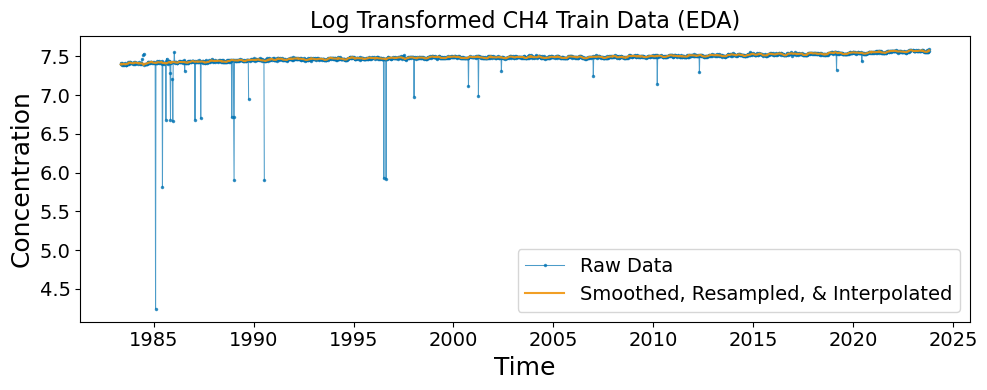

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.9846
ADF p-value 0.7588
ADF critical values: {'1%': -3.433481203206757, '5%': -2.862923230045995, '10%': -2.5675063669901363}

KPSS statistic 6.6824
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  


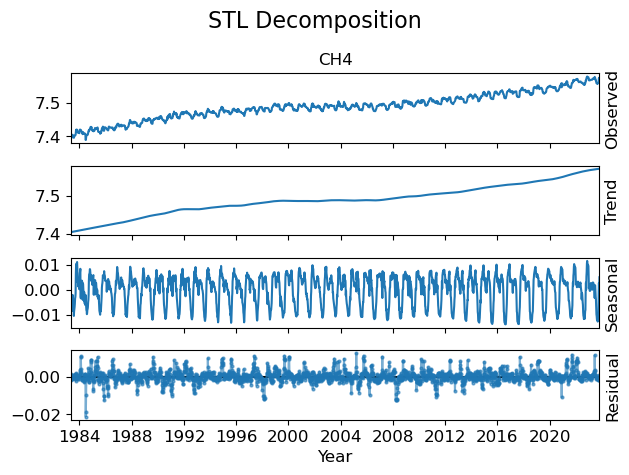

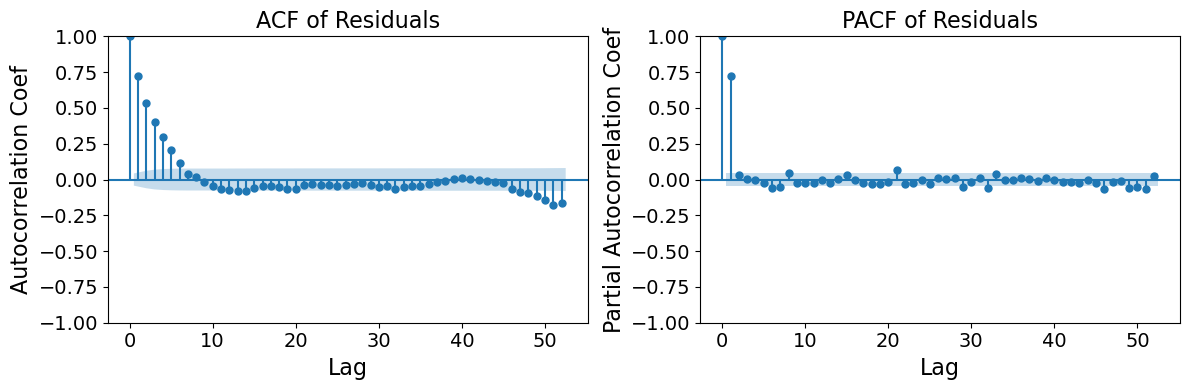


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0126
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0241
Heteroscedasticity detected (White test)
Trimming 388 leading NaN values


In [150]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

CH4_train_log_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True, transformation='log')
CH4_train_log_preprocessed = CH4_train_log_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'Log Transformed CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_test_with_date)

In [151]:
# verify data structure following transformation and preprocessing 

print('CH4_train shape:', CH4_train_with_date.shape)
print('CH4_test shape:', CH4_test_with_date.shape)

print('\nCH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

print('\nCH4_train_log_preprocessed shape:', CH4_train_log_preprocessed.shape)
print('CH4_test_log_preprocessed shape:', CH4_test_log_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)

CH4_train_preprocessed shape: (2111,)
CH4_test_preprocessed shape: (62,)

CH4_train_log_preprocessed shape: (2111,)
CH4_test_log_preprocessed shape: (62,)


**Comparison of Statistical Test Results Before and After Log Transformation of the Training Dataseries:**

- Non-transformed data:

    - ADF statistic: -1.0139, p-value: 0.7481

    - KPSS statistic: 6.6953, p-value: 0.0100

    - result:  the preprocessed data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0196

    - White test p-value: 0.0028

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

- Log-transformed data:

    - ADF statisti:c -0.9846, p-value: 0.7588

    - KPSS statistic: 6.6824, p-value: 0.0100

    - result:  the Processed Data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0126

    - White test p-value: 0.0241

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

Trend/Seasonality:

Log transformation did not affect stationarity, which is expected and will be addressed through differencing in the SARIMA model.

Heteroscedasticity

The log transformation helped slightly based on the White test result, but there is remaining variance in the residuals.

Autocorrelation patterns:

Prior to log transformation, the ACF plot of STL decomposition residuals shows an oscillatory behavior, which is greatly reduced after log transformation. This is an argument for log transformation since it simplifies the correlation structure and should help tune the SARIMA model orders.

Interpretation of ACF and PACF plots for SARIMA model orders:

The ACF plot shows a gradual decay in autocorrelation coefficient magnitude from lag 1 - 5 indicating non-stationarity requiring non-seasonal differencing. The strong spike at lag 1 in the PACF plot indicates first order differencing (d = 1). The significant lag at 52 is consistent with annual seasonality with weekly time points and suggests the need for seasonal differencing (D = 1).

The gradual decay of lags 1 - 5 of the ACF plot and sharp cut off after lag 1 on the PACF plot indicates an AR(1) process.

model suggestion (thus far): SARIMA(1,1,0)(0,1,0)52

# Difference Preprocessed/Log Transformed Train Data

Origninal series length: 2111
Non-seasonally differenced series length: 2110

[INFO] Stationarity tests on non-seasonally differenced series:
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -15.3100
ADF p-value 0.0000
ADF critical values: {'1%': -3.433485707610957, '5%': -2.8629252188514385, '10%': -2.5675074259130812}

KPSS statistic 0.0534
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  


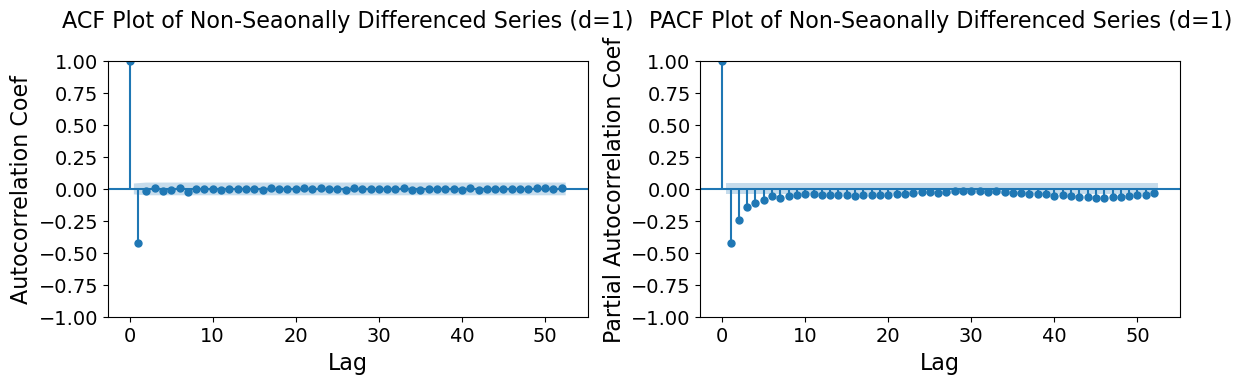

In [152]:
# I will first inspect the residuals of non-seasonally differenced log transformed train data to determine its effectiveness

nsdiffed_series = CH4_train_log_preprocessed.diff(1).dropna()

print(f'Origninal series length: {len(CH4_train_log_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on non-seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
CH4_train_log_preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')

**Interpretation of non-seasonal differencing**

After non-seasonal differencing (d = 1), the log transformed and preprocessed train data is now stationary according to both the ADF and KPSS tests.  

ACF and PACF plot results:  The gradual decay seen in the PACF plot along with the sharp cut off observed in the ACF plot indicates an MA process.  

ACF plot results:  One significant lag with sharp cutoff corroborates the ADF and KPSS test results that there is no remaining autocorrelation.  The single spike suggests an MA term, q = 1 for the non-seasonal component.  

PACF plot results:  Apparently the gradual decay is typical after differencing, though an AR term (AR(1)) might help.

Another important observation is that lags around 52 are no longer significant.  Seasonal differencing may not be necessary but will test its affect.  

Thus far:  p = 0 or 1, d = 1, q = 1


[INFO]: Stationarity tests on seasonally differenced series (D=1 only):
ADF and KPSS tests for seasonally differenced (D=1):
ADF statistic -17.1282
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335361251480934, '5%': -2.862947479232111, '10%': -2.5675192783016914}

KPSS statistic 0.3728
KPSS p-value 0.0889
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced (D=1) time series is likely stationary according to ADF and KPSS tests.



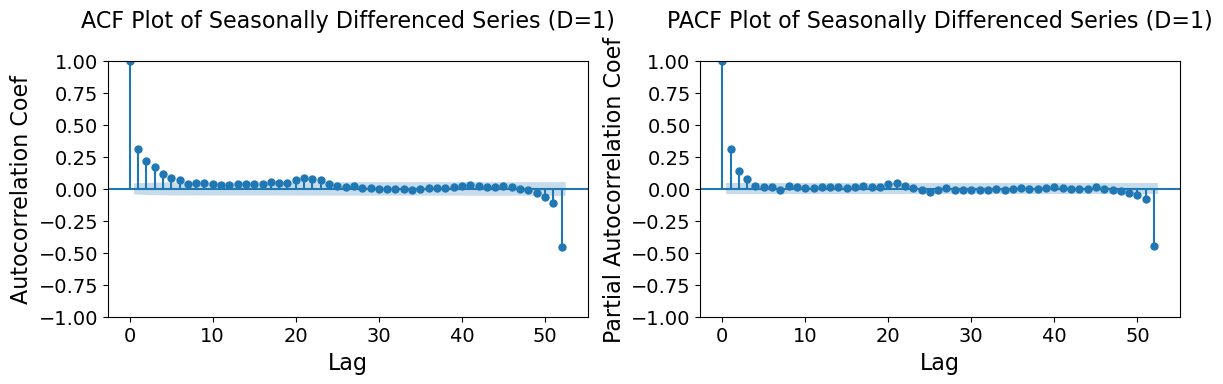

In [153]:
# Test the affect of only seasonal differencing (D=1)

# Apply only seasonal differencing (no non-seasonal)
sdiff = CH4_train_log_preprocessed.diff(52).dropna()

print('\n[INFO]: Stationarity tests on seasonally differenced series (D=1 only):')
CH4_train_log_preprocessor._run_stationarity_tests(sdiff, 'seasonally differenced (D=1)')

# Plot ACF/PACF
CH4_train_log_preprocessor.plot_acf_pacf(sdiff, 'Seasonally Differenced Series (D=1)')

**Interpretation of seasonal differencing**

Seasonal-only differencing also results in a stationary series.  However, the ACF and PACF plots are more complex compared to the non-seasonal-only differencing with gradual decay in both ACF and PACF non-seasonal lags as well as significant spikes at lag 52 (seasonal lag).  I will test the effects of combined non-seasonal and seasonal differening.  


[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:
ADF and KPSS tests for non-seasonally & seasonally differenced:
ADF statistic -16.8363
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335658957561157, '5%': -2.862960623392398, '10%': -2.567526276849711}

KPSS statistic 0.0458
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally & seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  


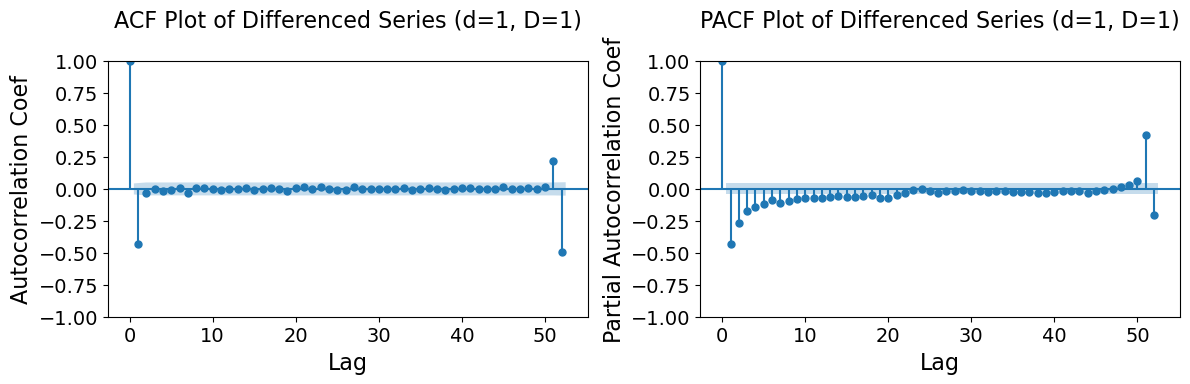

In [154]:
# Test the affect of non-seasonal and seasonal differencing (d=1, D=1)

snsdiffed_series = nsdiffed_series.diff(52).dropna()

# stationarity tests
print('\n[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(snsdiffed_series, 'non-seasonally & seasonally differenced')

# ACF and PACF plots
CH4_train_log_preprocessor.plot_acf_pacf(snsdiffed_series, 'Differenced Series (d=1, D=1)')

**Interpretation of differencing results:**

The non-seasonal-only differencing (d=1) is stationary and has the cleanest ACF and PACF plots.  Seasonal differencing also leads to stationarity but the residuals show some memory in both ACF and PACF lags.  It also leads to a significant spike at lag 52 in both ACF and PACF plots.  The combination of both non-seasonal and seasonal differencing may be inducing some artifacts as observed by the significant spikes at both lags 51 and 52. Additionally, there is a more complex pattern of decay in early lags of the PACF plot.  

conclusion:  non-seasonal only differencing effectively handles the CH4 trend and is likely sufficient for effective modeling and suggests that the annual seasonal pattern is stable.  

Non-seasonal-only differencing interpretation: 
- The ACF has a significant negative spike only at lag 1, which suggests a non-seasonal MA(1) term (q=1).
- The PACF shows a gradual decay (negative) from lags 1 - 5, which indicates an AR process. However, the fact that the ACF cuts off after lag 1 (except for the seasonal lags) suggests simplicity and will consider AR terms 0,1, and possibly 2, though may be adequately modeled with an MA(1) term only.
- Neither ACF or PACF plots show a significant spike at lag 52 suggesting seasonal orders (P,D,Q) of 0,0,0 as initial estimates.    

Candidate models to begin with:
- SARIMA(1,1,1)(0,0,0)52 - simple model, non-seasonal only
- SARIMA(1,1,1)(1,0,1)52 - captures both seasonal AR and MA
- SARIMA(0,1,1)(1,0,1)52 - non-seasonal MA only
- SARIMA(1,1,0)(1,0,1)52 - non-seasonal AR only
- SARIMA(1,1,1)(0,0,1)52 - seasonal MA only
- SARIMA(1,1,1)(1,0,0)52 - seasonal AR only

# Auto-ARIMA of the preprocessed/log transformed CH4 train set series

In [155]:
# at this point, the differencing orders are likely best set at d=1, D=0.
# I will use Auto-Arima to search for the best SARIMA model orders (p,q, and P,Q)
# information criterion = 'aic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (AIC)\n')

stepwise_model_log_aic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_aic.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (AIC)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-12639.402, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-13059.830, Time=15.06 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-13296.454, Time=61.32 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-12641.311, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-13292.915, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-13294.712, Time=67.26 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=-13297.490, Time=229.30 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=-13295.699, Time=512.17 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=-12635.238, Time=195.66 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=-13319.259, Time=371.04 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-13314.774, Time=100.11 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : AIC=-13292.784, Time=256.09 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : 

In [156]:
# at this point, the differencing orders are likely best set at d=1, D=0.
# I will use Auto-Arima to search for the best SARIMA model orders (p,q, and P,Q)
# information criterion = 'bic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (BIC)\n')

stepwise_model_log_bic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='bic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_bic.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (BIC)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=-12628.093, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=-13037.213, Time=14.08 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=-13273.836, Time=54.25 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=-12635.657, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : BIC=-13275.952, Time=0.44 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : BIC=-13274.272, Time=48.62 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : BIC=-13266.439, Time=58.87 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : BIC=-13284.954, Time=0.85 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : BIC=-13264.475, Time=50.83 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : BIC=-13286.502, Time=99.24 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : BIC=-13258.758, Time=77.02 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : BIC=-13285.333, Time=371.69 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : BIC=-1

**Interpretation of the results for log transformed/preprocessed train data fit to Auto Arima:**

- AIC: Best model:  ARIMA(2,1,1)(0,0,1)[52] intercept
- BIC: Best model:  ARIMA(2,1,1)(0,0,1)[52] intercept

The auto-ARIMA algorithm with AIC and BIC converged on the same SARIMA model orders, shown above.  AIC favors best fit despite complexity while BIC penalized complexity more heavily and favors a simpler model, therefore the agreement is a good indication of best model settings. All three non-seasonal terms (AR(L1), AR(L2), and MA(L1)), the one seasonal term (MA.S(L52)), and the intercept are all statistically significant.  Auto-ARIMA finds that one non-seasonal differencing (d = 1) and no seasonal differencing (D = 0) is optimal for both AIC and BIC, which corroborates the differencing tests performed above.  

Autocorrelation:  The Ljung-Box test null hypothesis is that the residuals are independently distributed, and therefore don't show autocorrelation.  

Heterscedasticity:  Both models show borderline statistically significant homoscedasticity (p = 0.06) in the fit residuals suggesting stable residual variance.   

Distribution of residuals:  The fit residuals are not normally distributed, which isn't ideal for SARIMA models. 

I will evaluate this and other similar models using TimeSeriesSplit cross validation.

# TimeSeriesSplit CV for validation

In [203]:
# Evaluate models using TimeSeriesSplit

models = [
    {'order': (2,1,1), 'seasonal_order': (1,0,0,52)},
    {'order': (2,1,1), 'seasonal_order': (0,0,1,52)}, # best model from auto-ARIMA
    {'order': (1,1,1), 'seasonal_order': (0,0,1,52)}, # based on EDA, seasonal MA only
    {'order': (1,1,1), 'seasonal_order': (1,0,0,52)}, # based on EDA, seasonal AR only
    {'order': (1,1,1), 'seasonal_order': (1,0,1,52)}, # based on EDA, seasonal and non-seasonal AR and MA
    {'order': (1,1,1), 'seasonal_order': (0,0,0,52)}, # based on EDA, simple model with no seasonal orders
    {'order': (0,1,1), 'seasonal_order': (1,0,1,52)}, # based on EDA, non-seasonal MA only
    {'order': (1,1,0), 'seasonal_order': (1,0,1,52)}, # best parameters base on first CV result, non-seasonal AR only
    {'order': (1,1,0), 'seasonal_order': (0,0,1,52)}, # based on first CV result, non-seasonal AR only, seasonal MA only
    {'order': (1,1,0), 'seasonal_order': (1,0,0,52)}, # based on first CV result, non-seasonal AR only, seasonal AR only
]

tscv = TimeSeriesSplit(n_splits=5)
results_summary = []

for params in models:
    rmse_scores, mae_scores = [], []
    aic_values, bic_values = [], []
    ljung_pvalues = []

    for train_idx, val_idx in tscv.split(CH4_train_log_preprocessed):
        train_fold = CH4_train_log_preprocessed.iloc[train_idx]
        val_fold = CH4_train_log_preprocessed.iloc[val_idx]

        model = SARIMAX(train_fold, order=params['order'], seasonal_order=params['seasonal_order'])
        results = model.fit(disp=False)

        # forecast
        forecast = results.get_forecast(steps=len(val_fold))
        forecast_values = forecast.predicted_mean

        # metrics
        rmse = np.sqrt(mean_squared_error(val_fold, forecast_values))
        mae = mean_absolute_error(val_fold, forecast_values)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

        # information criteria (in-sample only)
        aic_values.append(results.aic)
        bic_values.append(results.bic)

        # Ljung-Box test on residuals
        lb_test = acorr_ljungbox(results.resid, lags=[10], return_df=True)
        ljung_pvalues.append(lb_test['lb_pvalue'].values[0])

    results_summary.append({
        'order': params['order'],
        'seasonal_order': params['seasonal_order'],
        'RMSE_mean': np.mean(rmse_scores),
        'MAE_mean': np.mean(mae_scores),
        'AIC_mean': np.mean(aic_values),
        'BIC_mean': np.mean(bic_values),
        'Ljung_pval_mean': np.mean(ljung_pvalues)
    })

summary_df = pd.DataFrame(results_summary)
print(summary_df)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


       order seasonal_order  RMSE_mean  MAE_mean     AIC_mean     BIC_mean  \
0  (2, 1, 1)  (1, 0, 0, 52)   0.016679  0.014130 -6162.037253 -6137.919903   
1  (2, 1, 1)  (0, 0, 1, 52)   0.016693  0.014144 -6161.825730 -6137.708381   
2  (1, 1, 1)  (0, 0, 1, 52)   0.015871  0.013387 -6145.685594 -6126.391715   
3  (1, 1, 1)  (1, 0, 0, 52)   0.015867  0.013381 -6146.018751 -6126.724872   
4  (1, 1, 1)  (1, 0, 1, 52)   0.014969  0.012593 -6151.512607 -6127.395257   
5  (1, 1, 1)  (0, 0, 0, 52)   0.015854  0.013373 -6144.614569 -6130.144160   
6  (0, 1, 1)  (1, 0, 1, 52)   0.015101  0.012641 -6120.741230 -6101.447351   
7  (1, 1, 0)  (1, 0, 1, 52)   0.014834  0.012472 -5963.687986 -5944.394106   
8  (1, 1, 0)  (0, 0, 1, 52)   0.014834  0.012472 -5965.688051 -5951.217642   
9  (1, 1, 0)  (1, 0, 0, 52)   0.014829  0.012468 -5965.696335 -5951.225925   

   Ljung_pval_mean  
0              1.0  
1              1.0  
2              1.0  
3              1.0  
4              1.0  
5              

**Model Finalists Results Interpretation**

The model found by the initial TimeSeriesSplit, (1,1,0)(1,0,0,52), has the best/lowest RMSE and MAE scores suggesting that it has the best predictive performance of the four models.

The (2,1,1) models have the lowest AIC and BIC scores but highest RMSE and MAE scores. The better AIC and BIC scores, compared to the more simple (1,1,0)(1,0,0,52) model, combined with more complex orders may be due to overfitting.

The middling values of the (1,1,1)(0,0,0,52) model may be the sweet spot.

I will validate three models on the test set:

(2,1,1)(1,0,0,52)
(1,1,0)(1,0,0,52)
(1,1,1)(0,0,0,52)

# Screen Model Finalists

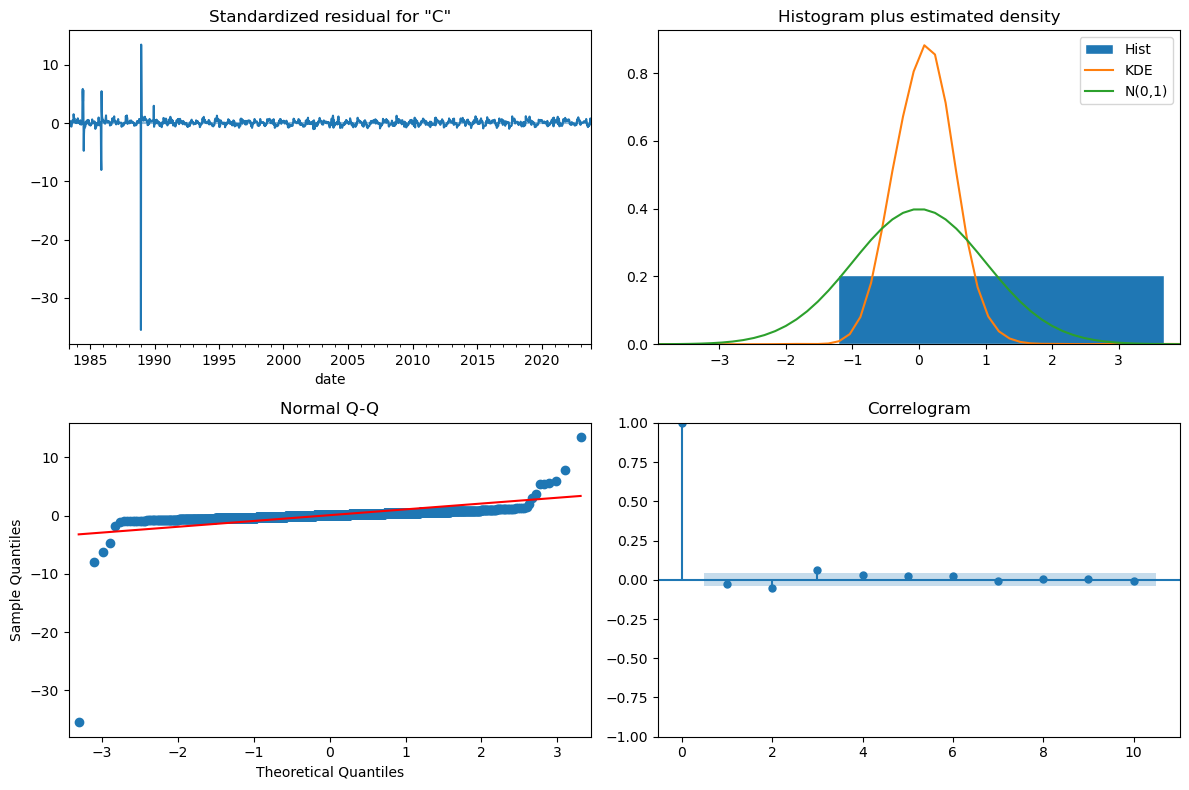

Ljung-Box p-values: [0.98401852 0.99979837 0.99999454 0.99999943 0.99999998 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]

Model Information Criteria:
AIC: -13361.7323
BIC: -13333.4601


In [204]:
# best model orders based on auto-ARIMA (AIC and BIC) and TimeSeriesSplit best AIC and BIC scores

model1 = SARIMAX(
    CH4_train_log_preprocessed,
    order=(2,1,1),
    seasonal_order=(1,0,0,52)
)

model1_results = model1.fit(disp=True)

# validate model diagnostics

residuals = model1_results.resid
model1_resid_fig = model1_results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
model1_lb_test = acorr_ljungbox(residuals, lags=20)
print(f"Ljung-Box p-values: {model1_lb_test['lb_pvalue'].values}")

print('\nModel Information Criteria:')
print(f'AIC: {model1_results.aic:.4f}')
print(f'BIC: {model1_results.bic:.4f}')

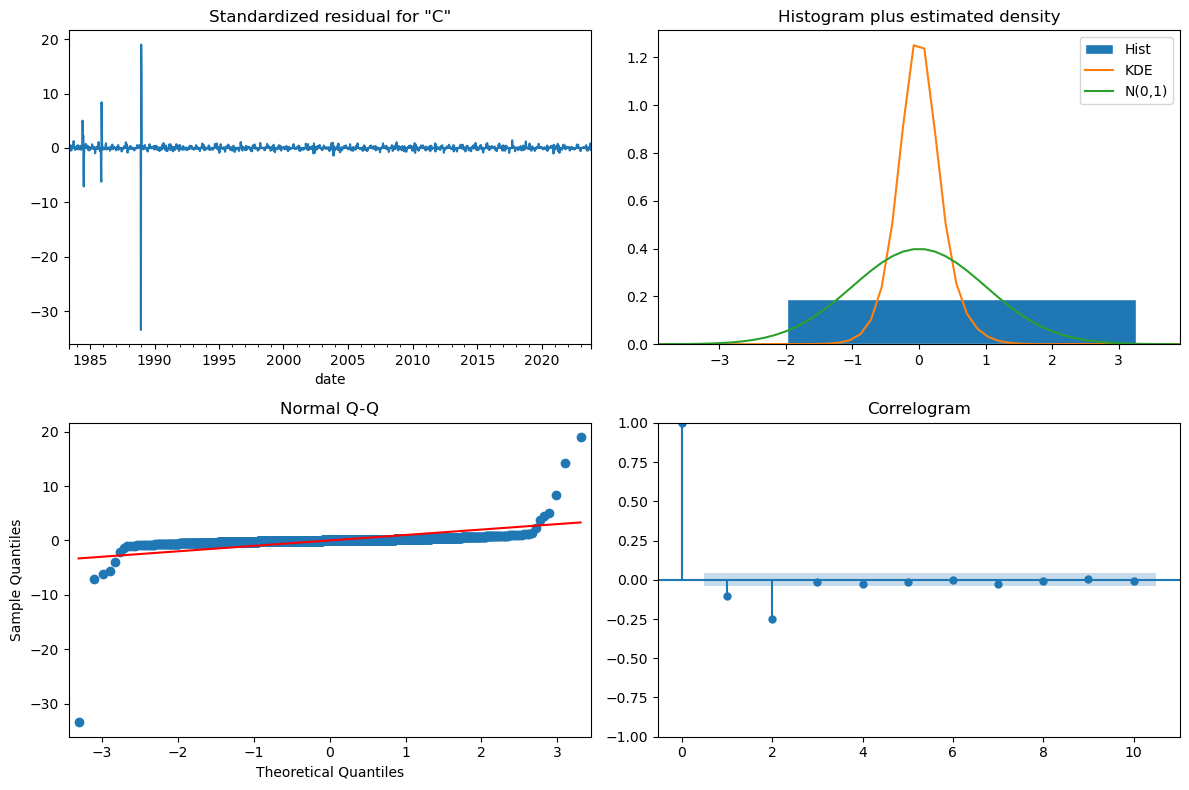

Ljung-Box p-values: [0.99464416 0.99915978 0.99996133 0.9999971  0.9999999  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]

Model Information Criteria:
AIC: -13061.6084
BIC: -13044.6451


In [205]:
# best model orders based on TimeSeriesSplit best/lowest RMSE and MAE

model2 = SARIMAX(
    CH4_train_log_preprocessed,
    order=(1,1,0),
    seasonal_order=(1,0,0,52)
)

model2_results = model2.fit(disp=True)

# validate model diagnostics

residuals = model2_results.resid
model2_resid_fig = model2_results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
model2_lb_test = acorr_ljungbox(residuals, lags=20)
print(f"Ljung-Box p-values: {model2_lb_test['lb_pvalue'].values}")

print('\nModel Information Criteria:')
print(f'AIC: {model2_results.aic:.4f}')
print(f'BIC: {model2_results.bic:.4f}')

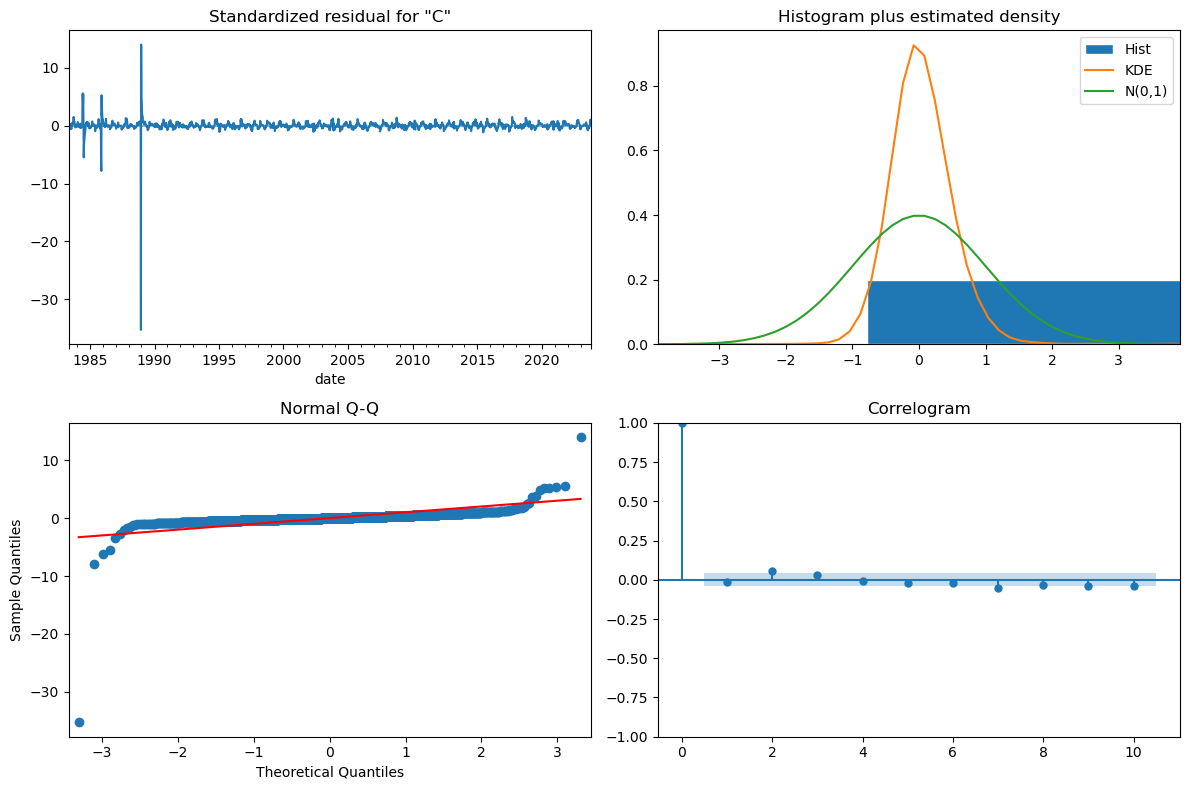

Ljung-Box p-values: [0.97950883 0.99946444 0.99998632 0.99999886 0.99999995 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]

Model Information Criteria:
AIC: -13307.9091
BIC: -13290.9457


In [206]:
# Model with middling values for RMSE, MAE, and AIC and BIC

model3 = SARIMAX(
    CH4_train_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(0,0,0,52)
)

model3_results = model3.fit(disp=True)

# validate model diagnostics

residuals = model3_results.resid
model3_resid_fig = model3_results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
model3_lb_test = acorr_ljungbox(residuals, lags=20)
print(f"Ljung-Box p-values: {model3_lb_test['lb_pvalue'].values}")

print('\nModel Information Criteria:')
print(f'AIC: {model3_results.aic:.4f}')
print(f'BIC: {model3_results.bic:.4f}')

**Model screen results:**

- all models produce residuals that have spikes at the beginning of the data series.  These spikes are likely artifacts of differencing "start-up" of the SARIMA model or outlier handling and interpolation during preprocessing.  However the residuals are very close to zero after 1990.

- The KDE plot shows a histogram that is shifted to the right indicating that the mean of the residuals is slightly positive.  The KDE is more sharply peaked with heavier tails compared to the normal curve. This, along with the QQ plot, confirms that the residuals deviate from a normal curve.  This deviation from normality can affect prediction intervals.

- The correlogram and Jjung-Box p-values (> 0.05) indicate homoescedasticity, meaning that the model sucessfully captured the patterns in the data.   

- SARIMA(2,1,1)(1,0,0)52 - best model (-13361.7323, -13333.4601)
- SARIMA(1,1,1)(0,0,0)52 - best for combination of order simplicity, metrics (AIC, BIC, RMSE, MAE), correlogram, and distribution.

# Evaluate Model Finalists

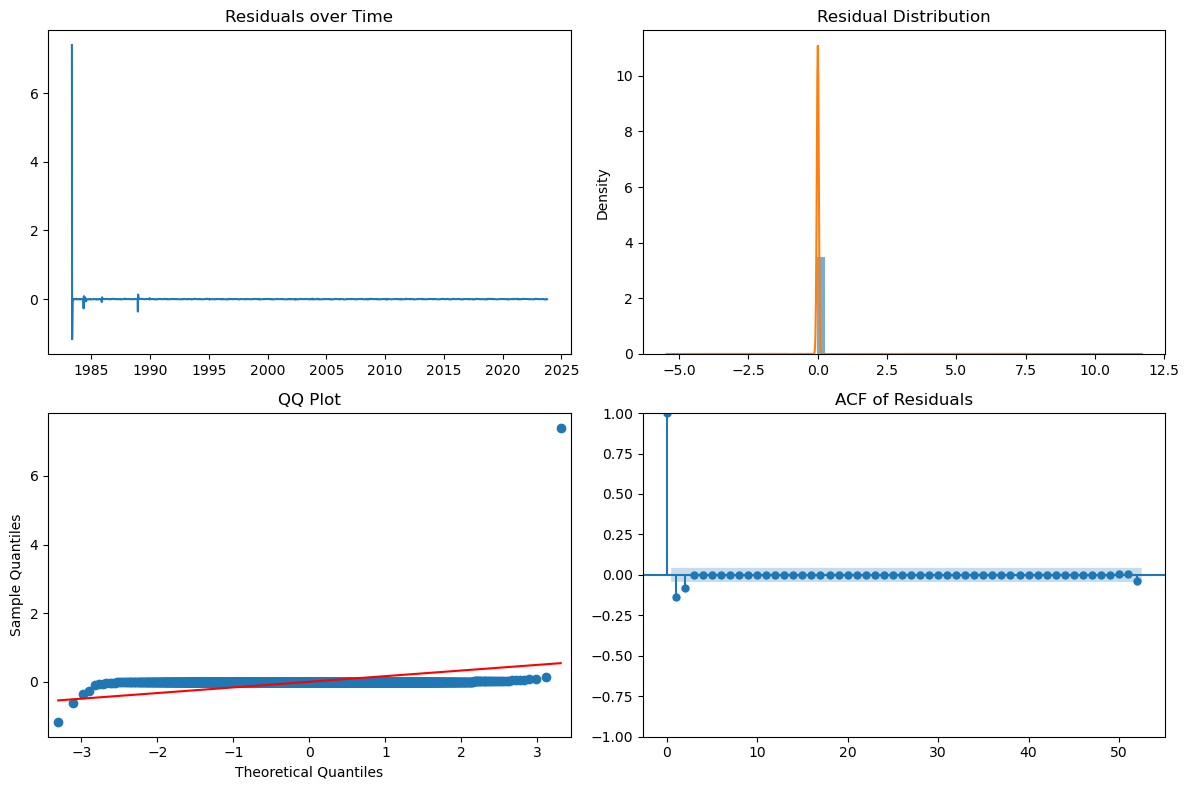

{'order': (2, 1, 1), 'seasonal_order': (1, 0, 0, 52), 'AIC': -12982.807, 'BIC': -12954.664, 'LB_pval_lag1': 0.0, 'LB_pval_lag4': 0.0, 'LB_pval_lag52': 0.2505, 'BP_LM': 3.216, 'BP_pval': 0.0729, 'BP_F': 3.218, 'BP_F_pval': 0.073, 'White_LM': 8.55, 'White_pval': 0.0139, 'White_F': 4.286, 'White_F_pval': 0.0139}


In [217]:
eval_211_10052 = evaluate_sarima_model(CH4_train_log_preprocessed,
                                       order = (2,1,1),
                                       seasonal_order = (1,0,0,52),
                                       run_hetero = True)

print(eval_211_10052)

### Model Performance Metrics  
(from respective model summaries)

**Optimization Method**: L-BFGS  

```text
Model 1: ARIMA(2,1,0)(2,0,1)[52]  
    AIC: -18144.344 | BIC: -18110.694  

Model 2: ARIMA(2,1,1)(2,0,1)[52]  
    AIC: -18180.986 | BIC: -18141.728  

Model 3: ARIMA(2,1,0)(1,0,0)[52]  
    AIC: -17122.350 | BIC: -17099.815  

Model 4: ARIMA(2,1,0)(0,0,0)[52]  
    AIC: -17571.405 | BIC: -17554.429  

MODEL 5: SARIMA(2,1,0)(1,0,2)[52]  **BEST**
    AIC: -18211.695 | BIC: -18178.040  

Model 6: SARIMA(1,1,0)(1,0,1)[52]  
    AIC: -17253.441 | BIC: -17230.904  
```

### Legend  
- **AIC**: Lower = Better (penalizes complexity)  
- **BIC**: Lower = Better (stronger penalty than AIC)  

**Best Model**: model 5 SARIMA(2,1,0)(1,0,2)[52]
- Model 5 has significantly lower AIC and BIC scores.  Its AIC score is 31 points lower than the model with the next lowest AIC score, and a BIC score that is 37 points lower.  A difference > 10 is considered substantial.
- Models 3, 4, and 6 have the highest AIC and BIC scores.
- Model 5, along with models 1-4 reject the Ljung_Box test H0 hypothesis for autocorrelation at all tested lags.  Model 6 failed to reject the H0 hypothesis at lag 52. So model 6 is ruled out in this grouping.
-  All models show no heteroscedasticity in trimmed residuals.
-  The QQ plot of model 5 appears to hug the red line at the tails more than other models.
-  Model 5 is simpler, uses fewer parameters, than models 1 and 2.

# Save Best Model Parameters for Production

In [71]:
import json
from datetime import datetime

model_config = {
    'model_type': 'SARIMAX',
    'order': (2,1,0),
    'seasonal_order': (1,0,2,52),
    'trend': 'n',
    'enforce_stationarity': False,
    'envorce_invertibility': False,
    'training_data_range': {
        'start': CH4_train_logged.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_logged.index[-1].strftime('%Y-%m-%d')
    },
    'fit_method': 'lbfgs',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('CH4 train set model configuration saved.  Re-fit in next notebook.')

CH4 train set model configuration saved.  Re-fit in next notebook.


# Save Logged Data for use in Forecasting

In [69]:
# define path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save the logged CH4 train data
CH4_train_logged.to_csv(
    output_dir / 'ch4_train_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_train_logged.csv"}')

Saved to: ..\data\processed\ch4_train_logged.csv


In [70]:
# save the logged CH4 test data
CH4_test_logged.to_csv(
    output_dir / 'ch4_test_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_test_logged.csv"}')

Saved to: ..\data\processed\ch4_test_logged.csv
